In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rounding = "round", abs_err = True):
    ufc_err_min_list = []
    ufc_err_max_list = []
    ufc_err_mean_list = []
    ufc_err_std_list = []
    
    ofc_err_min_list = []
    ofc_err_max_list = []
    ofc_err_mean_list = []
    ofc_err_std_list = []
    
    ifc_err_min_list = []
    ifc_err_max_list = []
    ifc_err_mean_list = []
    ifc_err_std_list = []
    
    x_label = []
    
    for bitwidth in range(6, 13):
        cycle = 2**(bitwidth-1)
        
        in_feature = 2
        out_feature = 2**12
        bias = False
        
        input = torch.cat(2*[(torch.arange(0, out_feature)/out_feature - 0.5).unsqueeze(1)], 1).to(device)
        input[:, 1] = 0.

        fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
        fc.weight.data = torch.cat(2*[(torch.arange(0, out_feature)/out_feature - 0.5).unsqueeze(1)], 1).to(device)
        fc.weight.data[:, 1] = 0.
        fc_o = fc(input)

        ufc = HUBLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, cycle=cycle, rounding=rounding).to(device)
        ufc_o = ufc(input)
        
        ofc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, keep_res="output", more_res="input", rounding=rounding).to(device)
        ofc_o = ofc(input)
        
        ifc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, keep_res="input",  more_res="input", rounding=rounding).to(device)
        ifc_o = ifc(input)
        
        if abs_err is True:
            ufc_err = (ufc_o - fc_o)
            ofc_err = (ofc_o - fc_o)
            ifc_err = (ifc_o - fc_o)
        else:
            ufc_err = (ufc_o - fc_o) / fc_o
            ofc_err = (ofc_o - fc_o) / fc_o
            ifc_err = (ifc_o - fc_o) / fc_o
        
        ufc_err_min_list.append(np.nanmin(ufc_err.cpu().detach().numpy()))
        ufc_err_max_list.append(np.nanmax(ufc_err.cpu().detach().numpy()))
        ufc_err_mean_list.append(np.nanmean(np.abs(ufc_err.cpu().detach().numpy())))
        ufc_err_std_list.append(np.nanstd(ufc_err.cpu().detach().numpy()))
        
        ofc_err_min_list.append(np.nanmin(ofc_err.cpu().detach().numpy()))
        ofc_err_max_list.append(np.nanmax(ofc_err.cpu().detach().numpy()))
        ofc_err_mean_list.append(np.nanmean(np.abs(ofc_err.cpu().detach().numpy())))
        ofc_err_std_list.append(np.nanstd(ofc_err.cpu().detach().numpy()))
        
        ifc_err_min_list.append(np.nanmin(ifc_err.cpu().detach().numpy()))
        ifc_err_max_list.append(np.nanmax(ifc_err.cpu().detach().numpy()))
        ifc_err_mean_list.append(np.nanmean(np.abs(ifc_err.cpu().detach().numpy())))
        ifc_err_std_list.append(np.nanstd(ifc_err.cpu().detach().numpy()))
        
        x_label.append(2**(bitwidth-1))
    return ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ofc_err_min_list, ofc_err_max_list, ofc_err_mean_list, ofc_err_std_list, ifc_err_min_list, ifc_err_max_list, ifc_err_mean_list, ifc_err_std_list, x_label


In [5]:
rounding = "round"
abs_err = True
ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ofc_err_min_list, ofc_err_max_list, ofc_err_mean_list, ofc_err_std_list, ifc_err_min_list, ifc_err_max_list, ifc_err_mean_list, ifc_err_std_list, x_label = test(rounding, abs_err)
print(ufc_err_mean_list)
print(ufc_err_std_list)
print()

print(ofc_err_mean_list)
print(ofc_err_std_list)
print()

print(ifc_err_mean_list)
print(ifc_err_std_list)
print()

print(x_label)

[0.0069212895, 0.0035012946, 0.0017546908, 0.0008671605, 0.00041784628, 0.00019199908, 8.145226e-05]
[0.008252516, 0.004191224, 0.0021110727, 0.001050008, 0.00051037845, 0.00023727161, 0.00010173569]

[0.012769948, 0.009957188, 0.006087754, 0.004752559, 0.002968327, 0.0023195662, 0.0014654145]
[0.017257549, 0.013471331, 0.008031704, 0.00629553, 0.0038512973, 0.0030308126, 0.0018835099]

[0.0014654145, 0.00072838337, 0.00036380833, 0.00018311724, 9.413352e-05, 5.086398e-05, 5.343508e-09]
[0.0018835099, 0.00093169947, 0.00046449967, 0.00023424467, 0.00012214974, 7.047733e-05, 7.1761765e-09]

[32, 64, 128, 256, 512, 1024, 2048]


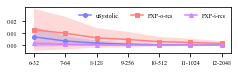

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family':'Times New Roman', 'size': 6}

matplotlib.rc('font', **font)

my_dpi = 300
fig_h = 1
fig_w = 3.3115

# construct some data like what you have:
x = np.array([i for i in range(len(ufc_err_mean_list))])
means1 = np.array(ufc_err_mean_list)
stds1 = np.array(ufc_err_std_list)
mins1 = np.array(ufc_err_min_list)
maxs1 = np.array(ufc_err_max_list)

means2 = np.array(ofc_err_mean_list)
stds2 = np.array(ofc_err_std_list)
mins2 = np.array(ofc_err_min_list)
maxs2 = np.array(ofc_err_max_list)

means3 = np.array(ifc_err_mean_list)
stds3 = np.array(ifc_err_std_list)
mins3 = np.array(ifc_err_min_list)
maxs3 = np.array(ifc_err_max_list)

x_label = ['6-32', '7-64', '8-128', '9-256', '10-512', '11-1024', '12-2048']

width = 0.20
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

ax.plot(x, means1, "-o", label="uSystolic", color="#7A81FF", ms=4)
ax.fill_between(x, means1-stds1, means1+stds1, alpha=0.3, color="#7A81FF", edgecolor=None)

ax.plot(x, means2, "-s", label="FXP-o-res", color="#FF7F7F", ms=4)
ax.fill_between(x, means2-stds2, means2+stds2, alpha=0.3, color="#FF7F7F", edgecolor=None)

ax.plot(x, means3, "-^", label="FXP-i-res", color="#D783FF", ms=4)
ax.fill_between(x, means3-stds3, means3+stds3, alpha=0.3, color="#D783FF", edgecolor=None)

ax.set_xticks(x)
ax.set_xticklabels(x_label)
ax.set_yscale('linear')
ax.set_yticks([0, 0.01, 0.02])
ax.set_yticklabels(["0.00", "0.01", "0.02"])
ax.legend(loc="upper right", ncol=3, frameon=False)

fig.tight_layout()
plt.show()
fig.savefig("test_kernel_linear_fxp_hub_compare_abs_err.pdf", bbox_inches='tight', dpi=my_dpi)


In [7]:
rounding = "round"
abs_err = False
ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ofc_err_min_list, ofc_err_max_list, ofc_err_mean_list, ofc_err_std_list, ifc_err_min_list, ifc_err_max_list, ifc_err_mean_list, ifc_err_std_list, x_label = test(rounding, abs_err)
print(ufc_err_mean_list)
print(ufc_err_std_list)
print()

print(ofc_err_mean_list)
print(ofc_err_std_list)
print()

print(ifc_err_mean_list)
print(ifc_err_std_list)
print()

print(x_label)

[0.31519514, 0.20126407, 0.124766946, 0.07530014, 0.044202533, 0.025094695, 0.013617556]
[0.37063196, 0.31381208, 0.2523589, 0.19604039, 0.1483346, 0.10953416, 0.07849869]

[0.41617545, 0.3425048, 0.2506161, 0.20254159, 0.14653338, 0.11702261, 0.083802424]
[0.53290904, 0.47514227, 0.3975655, 0.34841263, 0.28735542, 0.2500371, 0.2048385]

[0.083802424, 0.047077734, 0.026040172, 0.014202542, 0.0076552574, 0.004100135, 8.5901036e-08]
[0.2048385, 0.14483072, 0.10166737, 0.070793234, 0.04905121, 0.034698438, 1.7000609e-08]

[32, 64, 128, 256, 512, 1024, 2048]


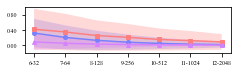

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family':'Times New Roman', 'size': 6}

matplotlib.rc('font', **font)

my_dpi = 300
fig_h = 1
fig_w = 3.3115

# construct some data like what you have:
x = np.array([i for i in range(len(ufc_err_mean_list))])
means1 = np.array(ufc_err_mean_list)
stds1 = np.array(ufc_err_std_list)
mins1 = np.array(ufc_err_min_list)
maxs1 = np.array(ufc_err_max_list)

means2 = np.array(ofc_err_mean_list)
stds2 = np.array(ofc_err_std_list)
mins2 = np.array(ofc_err_min_list)
maxs2 = np.array(ofc_err_max_list)

means3 = np.array(ifc_err_mean_list)
stds3 = np.array(ifc_err_std_list)
mins3 = np.array(ifc_err_min_list)
maxs3 = np.array(ifc_err_max_list)

x_label = ['6-32', '7-64', '8-128', '9-256', '10-512', '11-1024', '12-2048']

width = 0.20
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

ax.plot(x, means1, "-o", label="uSystolic", color="#7A81FF", ms=4)
ax.fill_between(x, means1-stds1, means1+stds1, alpha=0.3, color="#7A81FF", edgecolor=None)

ax.plot(x, means2, "-s", label="FXP-o-res", color="#FF7F7F", ms=4)
ax.fill_between(x, means2-stds2, means2+stds2, alpha=0.3, color="#FF7F7F", edgecolor=None)

ax.plot(x, means3, "-^", label="FXP-i-res", color="#D783FF", ms=4)
ax.fill_between(x, means3-stds3, means3+stds3, alpha=0.3, color="#D783FF", edgecolor=None)

ax.set_xticks(x)
ax.set_xticklabels(x_label)
ax.set_yscale('linear')
ax.set_yticks([0, 0.4, 0.8])
ax.set_yticklabels(["0.00", "0.40", "0.80"])
# ax.legend(loc="upper right", ncol=3, frameon=False)

fig.tight_layout()
plt.show()
fig.savefig("test_kernel_linear_fxp_hub_compare_rel_err.pdf", bbox_inches='tight', dpi=my_dpi)
